In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import os
import datetime
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_columns', 500)
from __future__ import print_function
import math
import csv
import glob

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std


# visualization
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
%matplotlib inline

#sentiment analysis
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords


# technical analaysis  
import talib

# machine learning
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
tf.logging.set_verbosity(tf.logging.ERROR)
from sklearn.preprocessing import MinMaxScaler

In [2]:
tweet_df = pd.read_csv('data/processed_tweet_data_1030-rows.csv')

In [5]:
tweet_df = tweet_df.drop(columns='Unnamed: 0')

In [3]:
price_df = pd.read_csv('data/processed_btc_price_data_2014-12-01_to_2018-11-11.csv')

In [6]:
price_df = price_df.drop(columns='Unnamed: 0')

In [7]:
price_tweet_df = (price_df.merge(tweet_df, on='date'))

In [8]:
price_tweet_df.describe()

,Close,tweet_len,sentiment_score_textBlob,sentiment_score_vader,pos_tweet_textBlob,neu_tweet_textBlob,neg_tweet_textBlob,pos_tweet_vader,neu_tweet_vader,neg_tweet_vader,pos-neg_textBlob,pos-neg_vader,neg-plus-neu_textBlob,posNeg-plusNeu_textBlob,neg-plus-neu_vader,posNeg-plusNeu_vader,signal_textBlob,signal_vader
count,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0,1012.0
mean,4009.0,170184.7,262.9,216.8,377.2,684.9,114.2,556.6,466.8,152.9,262.9,403.6,799.1,-422.0,619.7,-63.2,-0.9,-0.3
std,4106.9,185830.5,277.3,232.0,398.6,725.9,128.4,590.5,494.9,170.1,277.3,430.0,850.3,461.4,660.4,136.1,0.4,0.9
min,199.8,5338.0,3.0,-2.0,14.0,18.0,0.0,16.0,13.0,1.0,3.0,9.0,21.0,-1303.0,19.0,-622.0,-1.0,-1.0
25%,516.5,15028.8,34.0,26.3,43.0,70.0,8.0,63.0,48.0,11.0,34.0,49.0,78.0,-934.2,60.0,-98.2,-1.0,-1.0
50%,2342.8,33416.0,70.0,56.3,87.5,167.0,24.0,131.0,114.0,33.0,70.0,104.5,190.0,-106.0,147.0,-15.5,-1.0,-1.0
75%,6705.8,401183.2,566.0,472.1,844.0,1556.2,249.0,1254.0,1052.5,333.0,566.0,887.2,1844.0,-34.0,1404.2,9.0,-1.0,1.0
max,19419.9,448986.0,903.0,736.3,1108.0,1801.0,465.0,1599.0,1301.0,614.0,903.0,1324.0,2048.0,35.0,1699.0,487.0,1.0,1.0


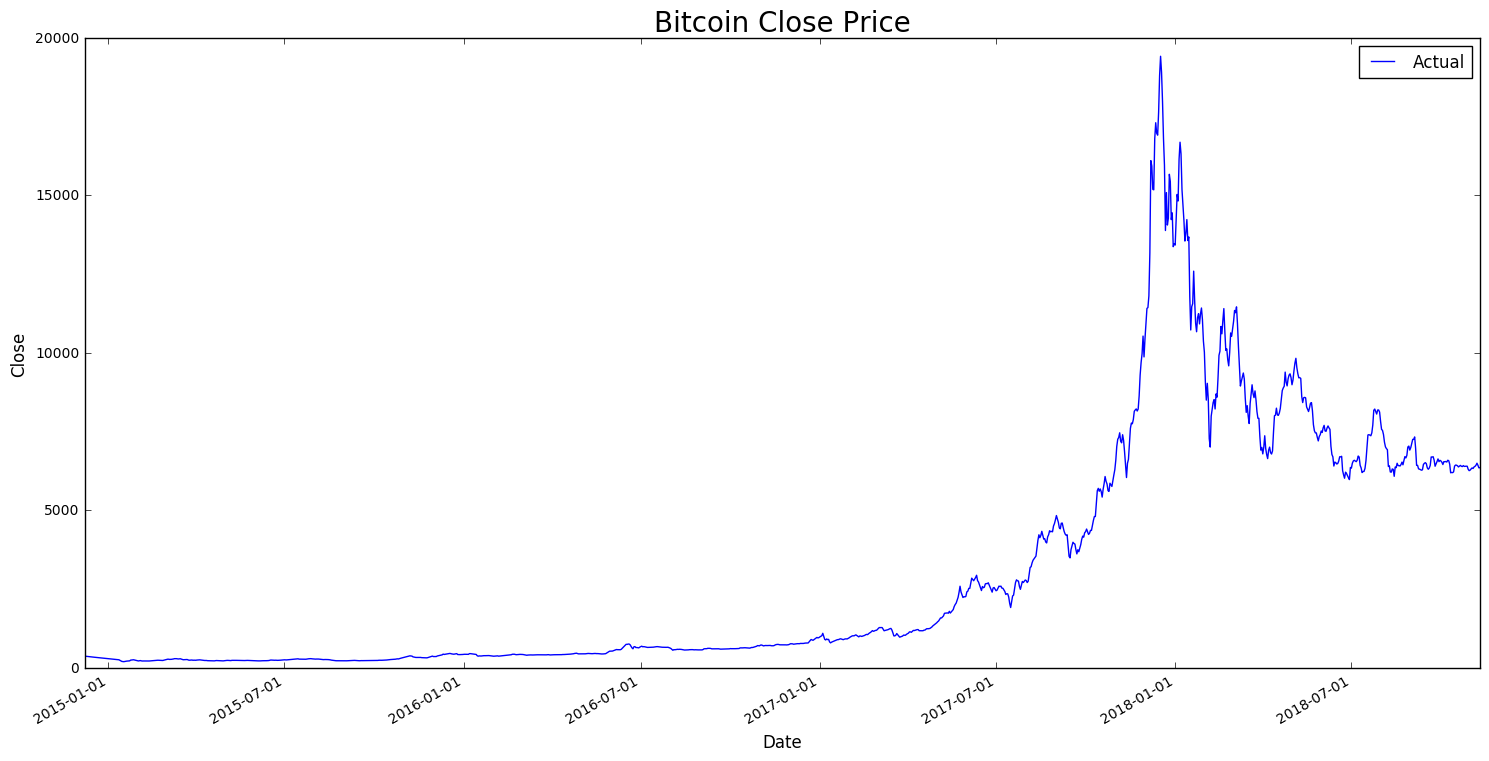

In [9]:
#preproces date col
dates_list_actual = list(price_tweet_df['date'])
dates_list_formatted_actual = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_actual]

# dates_list_training = list(price_tweet_df_training['date'])
# dates_list_formatted_training = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_training]

#dates_list_test = list(price_tweet_df['date'].tail(212))
#dates_list_formatted_test = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_test]

# price visualization
plt.figure(figsize = (18,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(dates_list_formatted_actual, price_tweet_df['Close'], color='b', label='Actual')
#plt.plot(dates_list_formatted_training, predictions, color='red', label='Training')
#plt.plot(dates_list_formatted_test, test_predictions, color='red', label='Test-Predicted')

plt.xlabel('Date',fontsize=12)
plt.ylabel('Close',fontsize=12)
plt.gcf().autofmt_xdate()
plt.title('Bitcoin Close Price',fontsize=20)
plt.ylim(-1,20000)
plt.legend()

In [11]:
def preprocess_features(price_tweet_df):
    """Prepares input features from price_tweet_dfdata set.

  Args:
    price_tweet_df: A Pandas DataFrame expected to contain feature data
  Returns:
    A DataFrame that contains the features to be used for the model.
  """
    selected_features = price_tweet_df[["pos_tweet_textBlob"]]
    processed_features = selected_features.copy()
    
    return processed_features

def preprocess_targets(price_tweet_df):
    """Prepares target features (i.e., labels) from price_tweet_df data set.

  Args:
    price_tweet_df: A Pandas DataFrame expected to contain target data
     
  Returns:
    A DataFrame that contains the target feature.
  """
    output_targets = pd.DataFrame()
    output_targets["Close"] = price_tweet_df["Close"]
    
    return output_targets

In [13]:
# training validation split
price_tweet_df_training_features = preprocess_features(price_tweet_df.head(800))
price_tweet_df_training_targets = preprocess_targets(price_tweet_df.head(800))

# price_tweet_df_validation_features = preprocess_features(price_tweet_df.head(200))
# price_tweet_df_validation_targets = preprocess_targets(price_tweet_df.head(200))

print("Training features summary:")
display.display(price_tweet_df_training_features.describe())

print("Training targets summary:")
display.display(price_tweet_df_training_targets.describe())

Training features summary:


,pos_tweet_textBlob
count,800.0
mean,247.1
std,345.0
min,14.0
25%,39.0
50%,61.0
75%,171.2
max,1108.0


Training targets summary:


,Close
count,800.0
mean,3185.6
std,4226.2
min,199.8
25%,422.6
50%,916.4
75%,4359.6
max,19419.9


In [14]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    Args:
    input_features: The names of the numerical input features to use.
    Returns:
    A set of feature columns
    """ 
    return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [15]:
def my_input_fn(features, targets, batch_size=1, shuffle=False, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
            
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [34]:
def train_nn_regression_model(
    my_optimizer, 
    steps, 
    batch_size, 
    hidden_units, 
    training_features,
    training_targets):
    """Trains a neural network regression model.
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `price_tweet_df`
          to use as input feature.
    Returns:
        A tuple (estimator, training_losses):
        estimator: the trained DNNRegressor object.
        training_losses: a list containg the training loss values taken during training.
        
  """
    periods = 10
    steps_per_period = steps / periods
    
    # Create a DNNRegressor object.
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_features),
        hidden_units=hidden_units,
        optimizer=my_optimizer
    )
    
    # Create input functions.
    training_input_fn = lambda:my_input_fn(training_features, 
                                           training_targets["Close"], 
                                           batch_size=batch_size)
    
    prediction_training_input_fn = lambda: my_input_fn(training_features, 
                                                       training_targets["Close"], 
                                                       num_epochs=1, 
                                                       shuffle=False)
   
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    
    for period in range(0, periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=prediction_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        # Compute loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_features))
        
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        
        # add the loss metrics from this period to our list
        training_rmse.append(training_root_mean_squared_error)
        
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    
    
#     # Output a table with calibration data.
#     calibration_data_final = pd.DataFrame()
#     calibration_data_final["predictions"] = pd.Series(predictions)
#     calibration_data_final["targets"] = pd.Series(targets)
#     display.display(calibration_data_final.describe())
    
    #preproces date col
    dates_list_actual = list(price_tweet_df['date'])
    dates_list_formatted_actual = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_actual]

    dates_list_training = list(price_tweet_df_training['date'])
    dates_list_formatted_training = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_training]

    # price visualization
    plt.figure(figsize = (18,9))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=0))

    plt.plot(dates_list_formatted_actual, price_tweet_df['Close'], color='b', label='Actual')
    plt.plot(dates_list_formatted_training, training_predictions, color='red', label='Training')

    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Close',fontsize=12)
    plt.gcf().autofmt_xdate()
    plt.title('Bitcoin Close Price',fontsize=20)
    plt.ylim(-1,20000)
    plt.legend()
    
    print("Final RMSE (on training data): %0.2f" % training_root_mean_squared_error)
    
    return dnn_regressor, training_rmse

Training model...
RMSE (on training data):
  period 00 : 1309.85
  period 01 : 1292.18
  period 02 : 1283.63
  period 03 : 1274.53
  period 04 : 1264.86
  period 05 : 1254.58
  period 06 : 1243.64
  period 07 : 1231.98
  period 08 : 1219.60
  period 09 : 1206.49
Model training finished.
Final RMSE (on training data): 1206.49


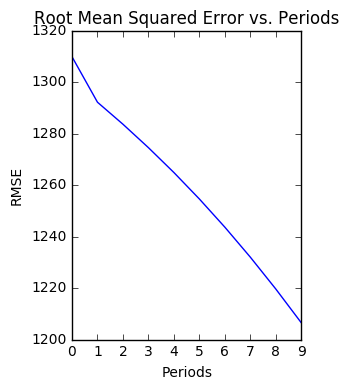

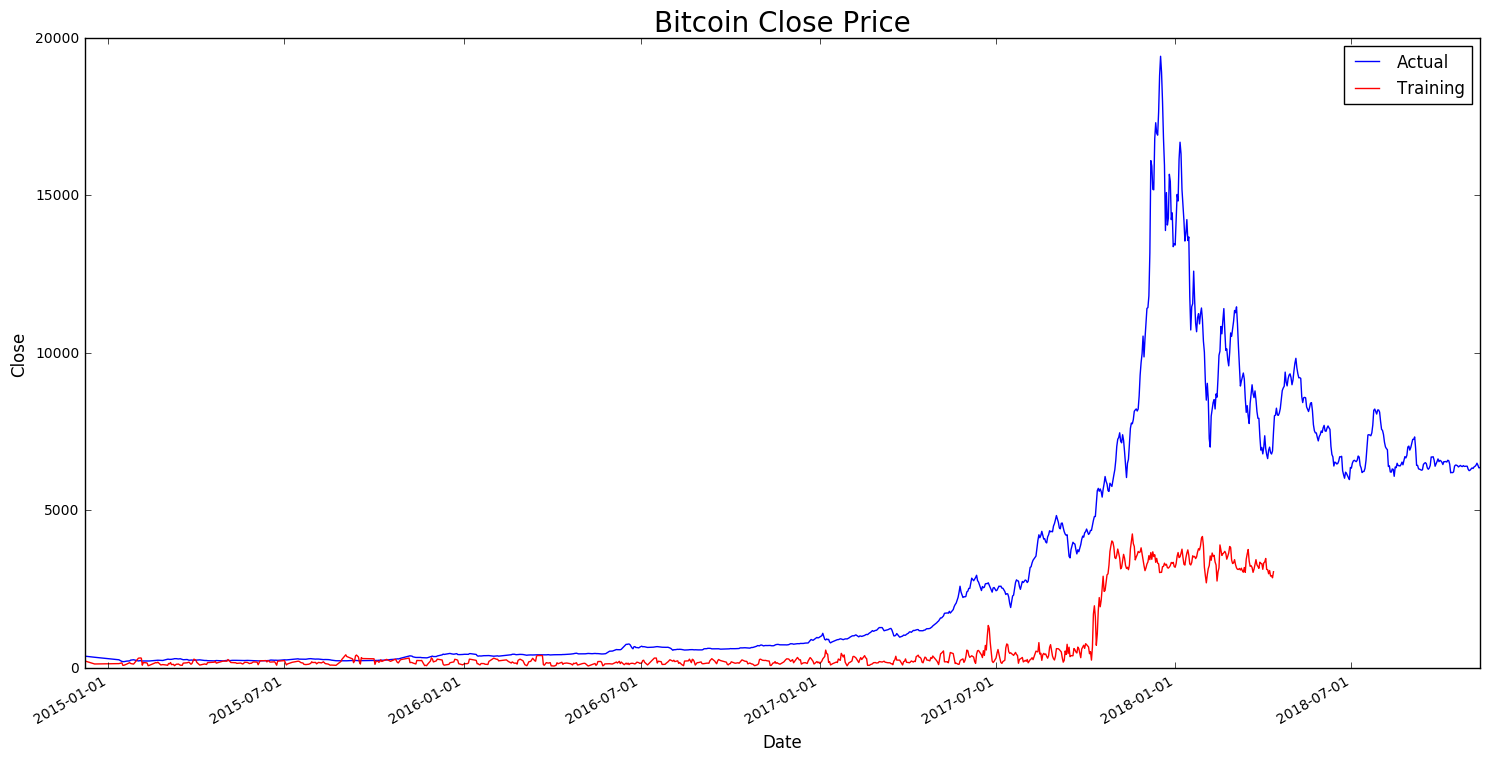

In [38]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.08),
    steps=500,
    batch_size=70,
    hidden_units=[10, 10],
    training_features=price_tweet_df_training_features,
    training_targets=price_tweet_df_training_targets)

In [39]:
def linear_scale(series):
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x:((x - min_val) / scale) - 1.0)

Training model...
RMSE (on training data):
  period 00 : 422.80
  period 01 : 421.36
  period 02 : 419.92
  period 03 : 418.50
  period 04 : 417.09
  period 05 : 415.69
  period 06 : 414.30
  period 07 : 412.92
  period 08 : 411.55
  period 09 : 410.19
Model training finished.
Final RMSE (on training data): 410.19


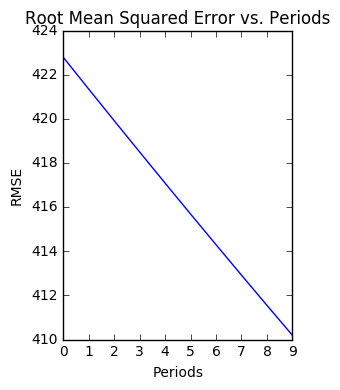

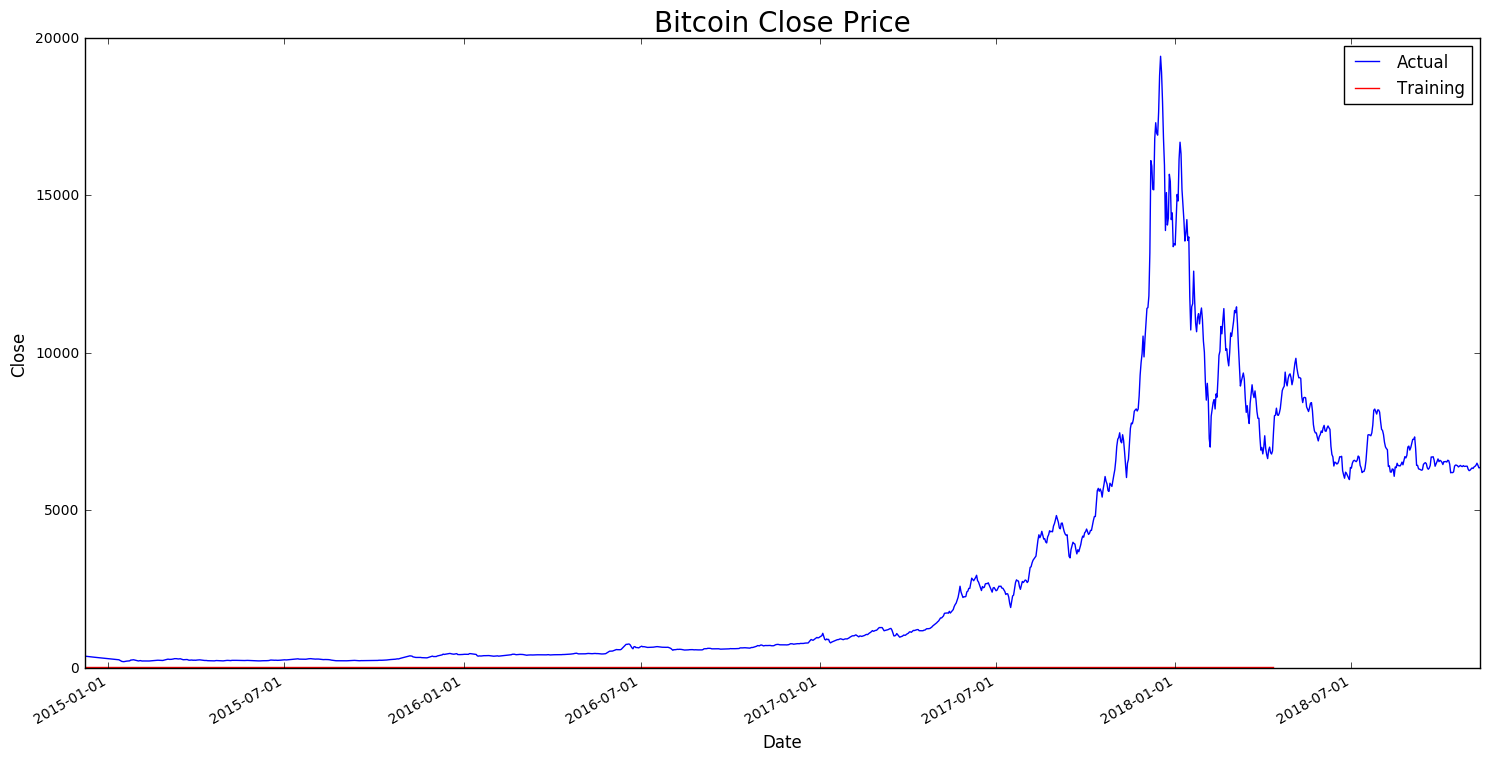

In [47]:
def normalize_linear_scale(features_dataframe):
    """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
    processed_features = pd.DataFrame()
    processed_features["pos_tweet_textBlob"] = linear_scale(features_dataframe["pos_tweet_textBlob"])
    return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(price_tweet_df))
normalized_training_features = normalized_dataframe.head(800)

dnn_regressor = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
    steps=500,
    batch_size=70,
    hidden_units=[10, 1],
    training_features=price_tweet_df_training_features,
    training_targets=price_tweet_df_training_targets)

In [48]:
price_tweet_df_test = price_tweet_df[800:]
len(price_tweet_df_test)

212

In [51]:
test_examples = preprocess_features(price_tweet_df_test)
test_targets = preprocess_targets(price_tweet_df_test)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["pos_tweet_textBlob"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

AttributeError: 'tuple' object has no attribute 'predict'